In [1]:
import tensorflow as tf
import keras
from keras import backend as K
from keras.layers.merge import _Merge
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
print(tf.__version__)
print(keras.__version__)
import cv2  # for image processing
from sklearn.model_selection import train_test_split
import scipy.io
import os
import h5py
from arts_preprocess_utils import load_dataset
from keras.preprocessing.image import ImageDataGenerator
from IPython import display
from wassertstein_utils import RandomWeightedAverage, gradient_penalty_loss, wasserstein_loss

/usr/local/lib/python3.6/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


1.8.0
2.1.6


In [2]:
BATCH_SIZE = 64
TRAINING_RATIO = 5  # The training ratio is the number of discriminator updates per generator update. The paper uses 5.
GRADIENT_PENALTY_WEIGHT = 10  # As per the paper

In [3]:
# !!! remember to clear session/graph if you rebuild your graph to avoid out-of-memory errors !!!
def reset_tf_session():
    K.clear_session()
    tf.reset_default_graph()
    s = K.get_session()
    return s

In [4]:
reset_tf_session()

## Load dataset

In [5]:
train_set_x_orig, train_set_y_orig, test_set_x_orig, test_set_y_orig = load_dataset('./wikiart_mini_portrait.h5')

In [6]:
img_Height = train_set_x_orig.shape[1]
img_Width = train_set_x_orig.shape[2]
N_CLASSES = len(np.unique(test_set_y_orig))

In [7]:
X_train = train_set_x_orig
y_train = train_set_y_orig

X_dev = test_set_x_orig
y_dev = test_set_y_orig

In [8]:
X_train = X_train * (1./255)

X_dev = X_dev * (1./255)

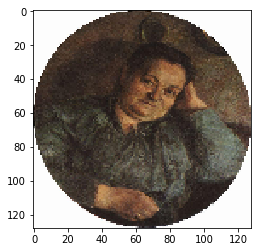

In [9]:
plt.imshow(X_train[0][...,::-1])

## Discriminator and generator base model

In [10]:
from models import Discriminator_model, Generator_model_complex

code_shape = 100

#based on art-DCGAN (robbiebarrat)
generator_model = Generator_model_complex(filters=80, code_shape= (1,1,code_shape))
generator = generator_model.get_model((img_Height, img_Width, 3))

#based on art-DCGAN (robbiebarrat)
discriminator_model = Discriminator_model(filters=40, code_shape=code_shape, include_top = False)
discriminator = discriminator_model.get_model((img_Height, img_Width, 3), N_CLASSES, False)

In [11]:
import keras.layers as L

#add top
discriminator.add(L.Flatten())
discriminator.add(L.Dense(1, kernel_initializer='he_normal'))

In [12]:
discriminator.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 64, 64, 40)        1960      
_________________________________________________________________
batch_normalization_7 (Batch (None, 64, 64, 40)        160       
_________________________________________________________________
leaky_re_lu_6 (LeakyReLU)    (None, 64, 64, 40)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 80)        51280     
_________________________________________________________________
batch_normalization_8 (Batch (None, 32, 32, 80)        320       
_________________________________________________________________
leaky_re_lu_7 (LeakyReLU)    (None, 32, 32, 80)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 16, 16, 160)       204960    
__________

In [13]:
generator.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_transpose_1 (Conv2DTr (None, 4, 4, 1280)        2049280   
_________________________________________________________________
batch_normalization_1 (Batch (None, 4, 4, 1280)        5120      
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 4, 4, 1280)        0         
_________________________________________________________________
conv2d_transpose_2 (Conv2DTr (None, 8, 8, 640)         13107840  
_________________________________________________________________
batch_normalization_2 (Batch (None, 8, 8, 640)         2560      
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 8, 8, 640)         0         
_________________________________________________________________
conv2d_transpose_3 (Conv2DTr (None, 16, 16, 320)       3277120   
__________

### Creater generator model

In [14]:
import keras.layers as L
from keras.models import Model
from keras.optimizers import Adam

#Define graph for generator

#discriminator.trainable = False
#generator.trainable = True

for layer in discriminator.layers:
    layer.trainable = False

for layer in generator.layers:
    layer.trainable = True

generator_input = L.Input(shape=(1,1,code_shape))
generator_layers = generator(generator_input)
discriminator_layers_for_generator = discriminator(generator_layers)
generator_model = Model(inputs=[generator_input], outputs=[discriminator_layers_for_generator])
# We use the Adam paramaters from Gulrajani et al.
generator_model.compile(optimizer=Adam(0.0001, beta_1=0.5, beta_2=0.9), loss=wasserstein_loss)

In [15]:
generator_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 1, 1, 100)         0         
_________________________________________________________________
sequential_1 (Sequential)    (None, 128, 128, 3)       19472255  
_________________________________________________________________
sequential_2 (Sequential)    (None, 1)                 5384721   
Total params: 24,856,976
Trainable params: 19,467,289
Non-trainable params: 5,389,687
_________________________________________________________________


### Create discriminator model

In [16]:
from keras.models import Model

#Define graph for discriminator

#discriminator.trainable = True
#generator.trainable = False

for layer in discriminator.layers:
    layer.trainable = True

for layer in generator.layers:
    layer.trainable = False

real_samples = L.Input(shape=X_train.shape[1:])
generator_input_for_discriminator = L.Input(shape=(1,1,code_shape))
generated_samples_for_discriminator = generator(generator_input_for_discriminator)
discriminator_output_from_generator = discriminator(generated_samples_for_discriminator)
discriminator_output_from_real_samples = discriminator(real_samples)
averaged_samples = RandomWeightedAverage(BATCH_SIZE)([real_samples, generated_samples_for_discriminator])
averaged_samples_out = discriminator(averaged_samples)

discriminator_model = Model(inputs=[real_samples, generator_input_for_discriminator],
                            outputs=[discriminator_output_from_real_samples,
                                     discriminator_output_from_generator,
                                     averaged_samples_out])

**Define loss fucntions**

In [17]:
from functools import partial

# The gradient penalty loss function requires the input averaged samples to get gradients. However,
# Keras loss functions can only have two arguments, y_true and y_pred. We get around this by making a partial()
# of the function with the averaged samples here.
partial_gp_loss = partial(gradient_penalty_loss,
                          averaged_samples=averaged_samples,
                          gradient_penalty_weight=10)
partial_gp_loss.__name__ = 'gradient_penalty'  # Functions need names or Keras will throw an error

In [18]:
discriminator_model.compile(optimizer=Adam(0.0001, beta_1=0.5, beta_2=0.9),
                            loss=[wasserstein_loss,
                                  wasserstein_loss,
                                  partial_gp_loss])

In [19]:
discriminator_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 1, 1, 100)    0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 128, 128, 3)  0                                            
__________________________________________________________________________________________________
sequential_1 (Sequential)       (None, 128, 128, 3)  19472255    input_3[0][0]                    
__________________________________________________________________________________________________
random_weighted_average_1 (Rand (None, 128, 128, 3)  0           input_2[0][0]                    
                                                                 sequential_1[2][0]               
__________

In [20]:
discriminator_model.metrics_names

['loss', 'sequential_2_loss', 'sequential_2_loss', 'sequential_2_loss']

## Training

In [21]:
positive_y = np.ones((BATCH_SIZE, 1), dtype=np.float32)
negative_y = -positive_y
dummy_y = np.zeros((BATCH_SIZE, 1), dtype=np.float32)

In [22]:
from gan_utils import noisy_images, sample_images, sample_probas

def train_gan(X, gen_size, epochs = 50000, sample_interval = 1000):

    for epoch in range(epochs):

        np.random.shuffle(X)
        d_loss_hist = []
        g_loss_hist = []
        size = (BATCH_SIZE,) + gen_size

        minibatches_size = BATCH_SIZE * TRAINING_RATIO
        for i in range(int(X.shape[0] // (BATCH_SIZE * TRAINING_RATIO))):

            # ---------------------
            #  Train Discriminator
            # ---------------------

            discriminator_minibatches = X[i * minibatches_size:(i + 1) * minibatches_size]


            for j in range(5):
                image_batch = discriminator_minibatches[j * BATCH_SIZE:(j + 1) * BATCH_SIZE]
                noise = np.random.normal(0, 1, size=size)
                d_loss =discriminator_model.train_on_batch([image_batch, noise], [positive_y, negative_y, dummy_y])


            # ---------------------
            #  Train Generator
            # ---------------------

            noise = np.random.normal(0, 1, size=size)

            g_loss = generator_model.train_on_batch( noise, positive_y)

        # Plot the progress 
        display.clear_output(wait=True)
        print ("%d [D loss: %f] [D(G(z)) loss: %f] loss: %f" % (epoch, d_loss[1], d_loss[2], d_loss[0]))
        g_loss_hist.append(g_loss)
        d_loss_hist.append(d_loss[0])
        sample_size = (1000,) + gen_size
        #TODO:change because discriminator do not classify between 0-1
        sample_probas(X, 1000, sample_size, discriminator=discriminator, generator=generator)

        # If at save interval => save generated image samples
        if epoch % sample_interval == 0:
            sample_images(epoch, gen_size, generator)
            #checkpoint to save weights
            generator.save_weights(filepath='generator_wasserstein.h5')
            discriminator.save_weights(filepath='discriminator_wasserstein.h5')

16 [D loss: -3.996259] [D(G(z)) loss: 0.958002] loss: -2.839741


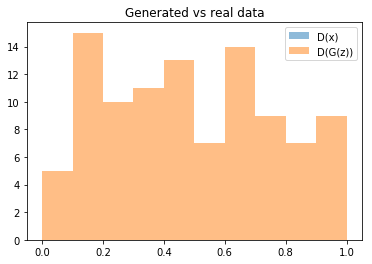

In [ ]:
train_gan(X=X_train, gen_size=(1,1,100))